## Import Libraries and Load Cifar10 Dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoded vectors
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)

2024-03-03 06:23:22.790229: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 06:23:22.950568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 06:23:22.950746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 06:23:22.971121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 06:23:23.031858: I tensorflow/core/platform/cpu_feature_guar

170498071/170498071 [==============================] - 2s 0us/step


## Prepare Tensorflow Datasets

In [2]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_onehot))
test_dataset = test_dataset.batch(len(x_test))

2024-03-03 06:23:53.049913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 06:23:53.517297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 06:23:53.517538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Convolutional Neural Network Model

In [3]:
class ConvolutionalNeuralNetwork(Model):
    def __init__(self, num_classes):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.num_classes = num_classes
        self.__build_layers()

    def __build_layers(self):
        # Convolutional layers
        self.conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3))
        self.conv2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')

        # Pooling layer
        self.pool = layers.MaxPooling2D(pool_size=(2, 2))

        # Flatten layer
        self.flatten = layers.Flatten()

        # Fully connected layers
        self.fc1 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))
        self.dropout = layers.Dropout(0.5)
        self.fc2 = layers.Dense(self.num_classes, activation='softmax')

    def call(self, inputs, training=False):
        # Forward pass through convolutional layers
        x = self.conv1(inputs)
        x = self.conv2(x)

        # Apply max pooling
        x = self.pool(x)

        # Forward pass through additional convolutional layer
        x = self.conv3(x)

        # Apply max pooling
        x = self.pool(x)

        # Flatten the output
        x = self.flatten(x)

        # Forward pass through fully connected layers
        x = self.fc1(x)

        # Apply dropout during training
        if training:
            x = self.dropout(x, training=training)

        # Output predictions
        return self.fc2(x)

## Train the model

In [4]:
def train_model(model, train_dataset, optimizer, loss_fn, train_loss_metric, train_accuracy_metric):
    # Iterate over the training dataset
    for images, labels in train_dataset:
        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(images)
            # Compute the loss
            loss = loss_fn(labels, predictions)

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        # Update model parameters
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Record training loss
        train_loss_metric(loss)
        # Record training accuracy
        train_accuracy_metric(labels, predictions)


## Test the model

In [5]:
def test_model(model, test_dataset, loss_fn, test_loss_metric, test_accuracy_metric):
    # Iterate over the test dataset
    for images, labels in test_dataset:
        # Forward pass
        predictions = model(images)
        # Compute the loss
        loss = loss_fn(labels, predictions)
        # Record test loss
        test_loss_metric(loss)
        # Record test accuracy
        test_accuracy_metric(labels, predictions)


## Plot the training and testing losses and accuracy

In [6]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot training and testing loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # Plot training and testing accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.show()

## Train and Evaluate the model by running epochs

In [8]:
# Instantiate the model
model = ConvolutionalNeuralNetwork(num_classes=10)

# Define the loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# Lists to store training and testing metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
epochs = 10
for epoch in range(epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    # Training
    train_model(model, train_dataset, optimizer, loss_fn, train_loss, train_accuracy)

    # Testing
    test_model(model, test_dataset, loss_fn, test_loss, test_accuracy)

    # Record metrics for plotting
    train_losses.append(train_loss.result())
    train_accuracies.append(train_accuracy.result() * 100)
    test_losses.append(test_loss.result())
    test_accuracies.append(test_accuracy.result() * 100)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100))

Epoch 1, Loss: 1.3546, Accuracy: 51.29%, Test Loss: 1.0725, Test Accuracy: 61.30%
Epoch 2, Loss: 0.8815, Accuracy: 69.30%, Test Loss: 0.8178, Test Accuracy: 71.84%
Epoch 3, Loss: 0.6812, Accuracy: 76.02%, Test Loss: 0.7894, Test Accuracy: 73.28%
Epoch 4, Loss: 0.5297, Accuracy: 81.49%, Test Loss: 0.7973, Test Accuracy: 73.25%
Epoch 5, Loss: 0.3907, Accuracy: 86.27%, Test Loss: 0.8431, Test Accuracy: 74.77%
Epoch 6, Loss: 0.2657, Accuracy: 90.63%, Test Loss: 0.9777, Test Accuracy: 74.05%
Epoch 7, Loss: 0.1747, Accuracy: 93.87%, Test Loss: 1.1478, Test Accuracy: 73.69%
Epoch 8, Loss: 0.1225, Accuracy: 95.77%, Test Loss: 1.2333, Test Accuracy: 73.82%
Epoch 9, Loss: 0.0933, Accuracy: 96.80%, Test Loss: 1.3224, Test Accuracy: 72.40%
Epoch 10, Loss: 0.0851, Accuracy: 97.02%, Test Loss: 1.4876, Test Accuracy: 73.12%


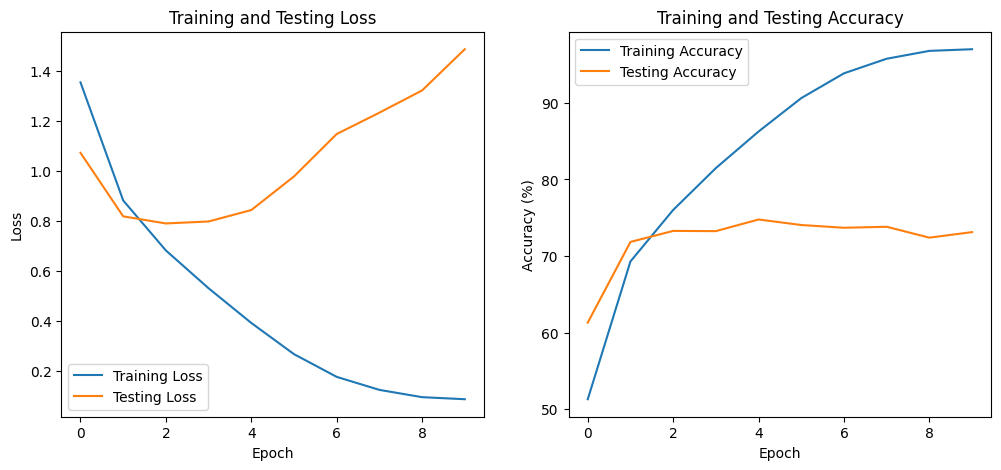

In [9]:
# Plotting training and testing metrics
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

## Grad Cam

In [11]:
class GradCAM(object):

    def __init__(self, model):
        self.model = model

    def heatmap(self, image):
        # Forward pass to get the output feature space
        features = self.model(image)

        # Identify the most probable class
        predicted_class = tf.argmax(features, axis=1).numpy()[0]

        with tf.GradientTape() as tape:
            # Watch the input image
            tape.watch(image)
            # Forward pass
            features = self.model(image)
            # Get the score for the predicted class
            predicted_score = features[0][predicted_class]

        # Calculate gradients of the predicted class
        gradients = tape.gradient(predicted_score, image)

        # Calculate activation map
        heat_map = tf.reduce_mean(gradients, axis=(0, 3))

        # Apply ReLU to obtain the CAM
        heat_map = tf.nn.relu(heat_map)

        return heat_map.numpy()

    def overlay_plot(self, image, cmap):
        heat_map = self.heatmap(image)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['Original Image', 'Grad CAM Heatmap', 'Grad CAM Overlay Plot']

        # Plot original image
        ax[0].imshow(image[0])
        ax[0].set_title(titles[0])

        # Plot Grad CAM heatmap
        heatmap = ax[1].imshow(heat_map, cmap=cmap)  # Using specified colormap
        ax[1].set_title(titles[1])
        plt.colorbar(heatmap, ax=ax[1])

        # Resize and overlay Grad CAM heatmap on the original image
        reshaped_heatmap = tf.expand_dims(heat_map, axis=-1)  # Expand dimensions along the last axis
        overlayed_activation_map = tf.image.resize(reshaped_heatmap, image.shape[1:3])
        overlayed_activation_map = tf.squeeze(overlayed_activation_map)  # Remove extra dimensions
        ax[2].imshow(image[0])
        heatmap = ax[2].imshow(overlayed_activation_map, cmap=cmap, alpha=0.5)
        ax[2].set_title(titles[2])
        plt.colorbar(heatmap, ax=ax[2])

        plt.show()

## Randomly Generate Results from Train Dataset

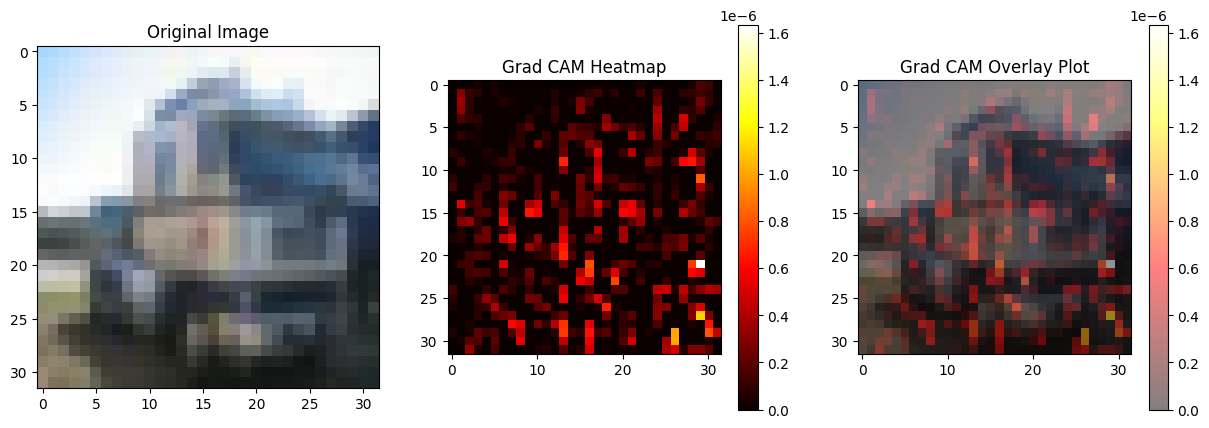

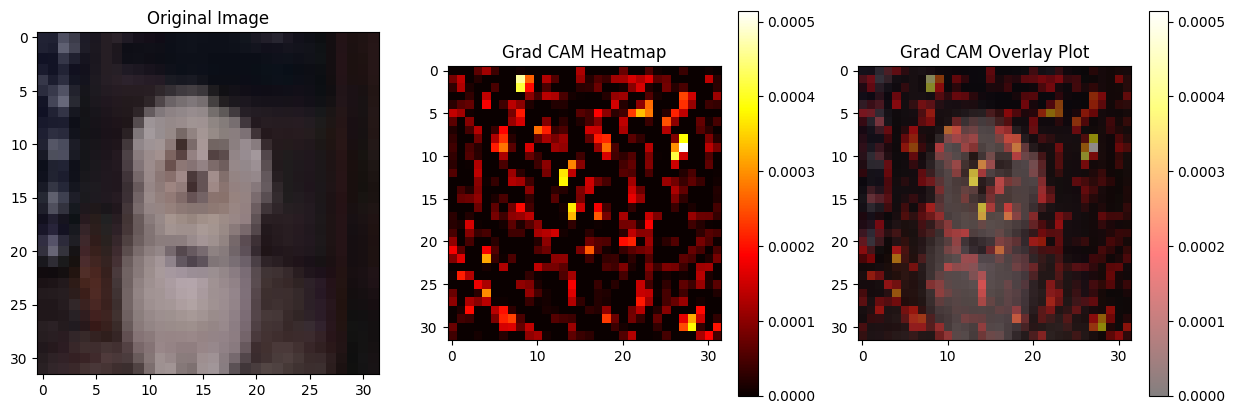

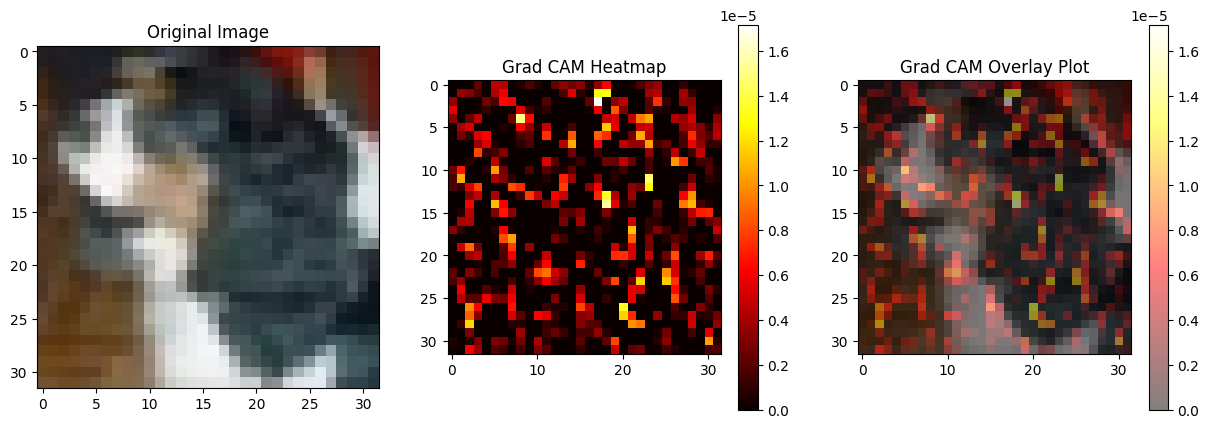

In [40]:
grad_cam = GradCAM(model)

# Generate a random index
num_samples = len(train_dataset)

for i in range(3):
    random_index = np.random.randint(0, num_samples)
    
    # Iterate over the train dataset to get the random image and label
    for i, (image, label) in enumerate(train_dataset):
        if i == random_index:
            break
    
    # Plot the heatmap for the random image
    cmap = 'hot'
    grad_cam.overlay_plot(image, cmap)